$$
H = \frac{|p|^2}2 + \alpha \sin(\theta t) s + \frac{\gamma}{|q|}
$$

In [1]:
from integrators import contact as ic
from integrators.common import rk4

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fast') #alt: 'seaborn-white'

#plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'font.weight':'normal'})
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['mathtext.fontset'] = "cm"

In [3]:
class TimePerturbedKepler:
    def __init__(self, alpha, theta, gamma):
        self.theta = theta
        self.alpha = alpha
        self.gamma = gamma

    def f(self, t):
        return self.alpha*np.sin(self.theta*t)

    def V(self, q, t):
        return self.gamma/np.linalg.norm(q, ord=2)
    
    def Vq(self, q, t):
        return -q*self.gamma/np.linalg.norm(q, ord=2)**3
    
    def lag(self, q,v,z,t):
        return .5*np.linalg.norm(v)**2 - self.V(q,t) - self.f(t)*z
    
    def lagq(self, q,v,z,t):
        return -self.Vq(q,t)
    
    def lagv(self, q,v,z,t):
        return v
    
    def lagz(self, q,v,z,t):
        return -self.f(t)
    
    def energy(self, p, q, z, t):
        return 0.5*np.linalg.norm(p, ord=2)**2 + self.f(t) + self.V(q, t)

In [4]:
e = 0.4
init_ecc = lambda e: [np.array([1.0 - e, 0.0]), np.array([0.0, np.sqrt((1+e)/(1-e))])]
init = init_ecc(e)

energy = lambda pq, z: [tpk.energy(pq[:,0][i], pq[:,1][i], z[i], t) for i,t in enumerate(tspan)]

## RK4 comparisons

/Users/mseri/code/contact-integrators/integrators/common.py:14: MatplotlibDeprecationWarning: scipy.integrate.ode
  return plb.rk4(derivs, init, tspan)


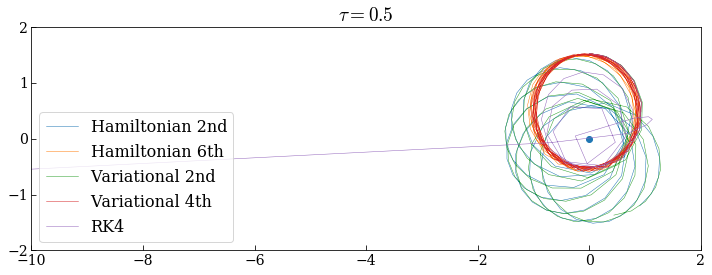

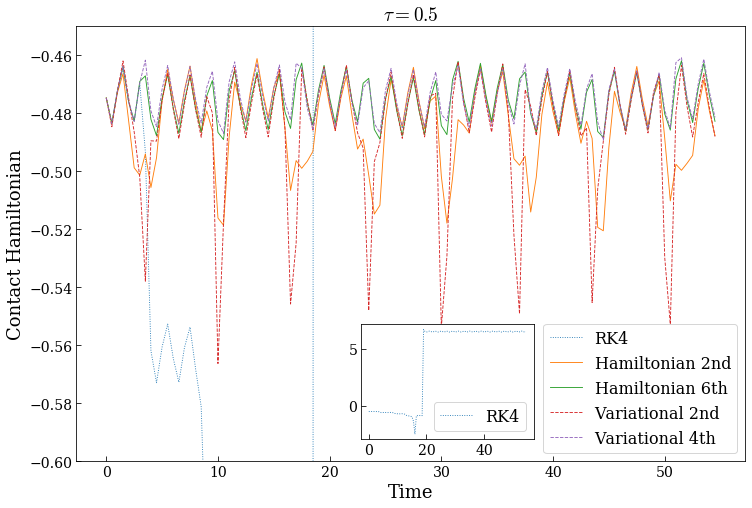

In [5]:
tpk = TimePerturbedKepler(-0.01, np.pi, -1)
dt = 0.5
tf = 55

tspan = np.arange(0.0, tf, dt)

for (p0, q0) in [init]:
    plt.figure(figsize=(12,8))
    plt.title(f"$\\tau={dt}$")
    
    sol, sols, tspan = ic.integrate(ic.step, tpk, tspan, p0, q0, 0.0)
    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)
    solrk = rk4(tpk, np.concatenate([p0,q0]), tspan)
    solsc, solscs, _ = ic.integrate(ic.variational_step, tpk, tspan, p0, q0, 0.0)
    sollag, sollags, _ = ic.integrate(ic.step_lag4, tpk, tspan, p0, q0, 0.0)

#     sole, _, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
#     solb, _, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
#     solc, _, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    
    plt.plot(sol[:,1,0],
             sol[:,1,1],
             linewidth=0.5, label="Hamiltonian 2nd")
    plt.plot(solm[:,1,0],
             solm[:,1,1],
             linewidth=0.5, label="Hamiltonian 6th")
    
    plt.plot(solsc[:,1,0],
             solsc[:,1,1],
             linewidth=0.5, label="Variational 2nd")
    plt.plot(sollag[:,1,0],
             sollag[:,1,1],
             linewidth=0.5, label="Variational 4th")
    
    plt.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             linewidth=0.5, label="RK4")

#     plt.plot(sole[:,1,0],
#              sole[:,1,1],
#              linewidth=0.5, label="Hamiltonian 6th e")
#     plt.plot(solb[:,1,0],
#              solb[:,1,1],
#              linewidth=0.5, label="Hamiltonian 6th b")
#     plt.plot(solc[:,1,0],
#              solc[:,1,1],
#              linewidth=0.5, label="Hamiltonian 6nd c")
    
    plt.scatter(0,0)
    
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.xlim(-10, 2)
    plt.ylim(-2, 2)

    plt.legend(loc='lower left')
    plt.show()
    
    
    fig = plt.figure(figsize=(12,8))
    
    axL = fig.add_subplot(1,1,1)
    axS = fig.add_axes([0.455,0.163,0.2,0.2])
    axS.plot(tspan,
             [tpk.energy(solrk[i][:2], solrk[i][2:], 0.0, t) for i,t in enumerate(tspan)],
             ":",
             linewidth=0.9, label="RK4")
    axS.legend(loc='lower right')
    
    axL.set_title(f"$\\tau={dt}$")
    axL.plot(tspan,
             [tpk.energy(solrk[i][:2], solrk[i][2:], 0.0, t) for i,t in enumerate(tspan)],
             ":",
             linewidth=0.9, label="RK4")
    
    axL.plot(tspan,
             energy(sol, sols),
             linewidth=0.9, label="Hamiltonian 2nd")

    axL.plot(tspan,
             energy(solm, solms),
             linewidth=0.9, label="Hamiltonian 6th")
    
    axL.plot(tspan,
             energy(solsc, solscs),
             '--',
             linewidth=0.9, label="Variational 2nd")
    
    axL.plot(tspan,
             energy(sollag, sollags),
             '--',
             linewidth=0.9, label="Variational 4th")
    
    axL.legend(loc='lower right')
    axL.set_ylim(-0.6,-0.45)
    axL.set_ylabel("Contact Hamiltonian")
    axL.set_xlabel("Time")
    plt.show()

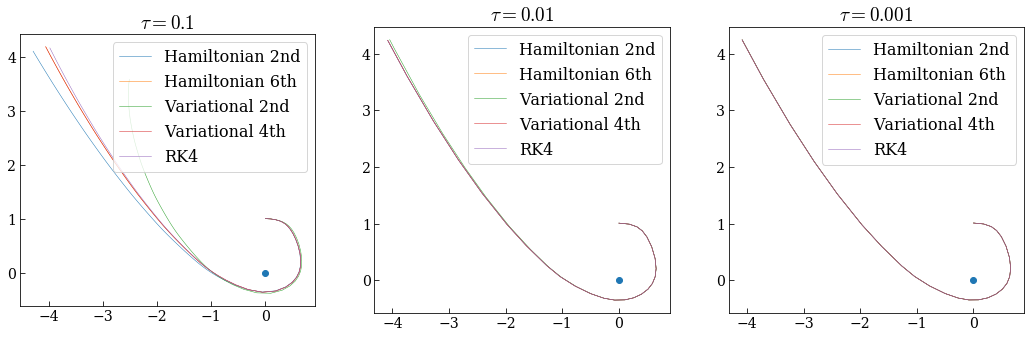

In [6]:
tpk = TimePerturbedKepler(1.7, 2*np.pi, -1)
tf = 10

(p0, q0) = init_ecc(0.01)

plt.figure(figsize=(18,12))

subplots = ["131", "132", "133"]

for i,precision in enumerate([10, 100, 1000]):
    dt = 1/precision
    tspan = np.arange(0.0, tf, dt)
    plt.subplot(subplots[i])
    plt.title(f"$\\tau={dt}$")
    
    sol, sols, tspan = ic.integrate(ic.step, tpk, tspan, p0, q0, 0.0)
    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)
    solrk = rk4(tpk, np.concatenate([p0,q0]), tspan)
    solsc, solscs, _ = ic.integrate(ic.variational_step, tpk, tspan, p0, q0, 0.0)
    sollag, sollags, _ = ic.integrate(ic.step_lag4, tpk, tspan, p0, q0, 0.0)
    
#     sole, _, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
#     solb, _, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
#     solc, _, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    
    plt.plot(sol[:,1,0],
             sol[:,1,1],
             linewidth=0.5, label="Hamiltonian 2nd")
    plt.plot(solm[:,1,0],
             solm[:,1,1],
             linewidth=0.5, label="Hamiltonian 6th")
    
    plt.plot(solsc[:,1,0],
             solsc[:,1,1],
             linewidth=0.5, label="Variational 2nd")
    plt.plot(sollag[:,1,0],
             sollag[:,1,1],
             linewidth=0.5, label="Variational 4th")
    
    plt.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             linewidth=0.5, label="RK4")

#     plt.plot(sole[:,1,0],
#              sole[:,1,1],
#              linewidth=0.5, label="Hamiltonian 6th e")
#     plt.plot(solb[:,1,0],
#              solb[:,1,1],
#              linewidth=0.5, label="Hamiltonian 6th b")
#     plt.plot(solc[:,1,0],
#              solc[:,1,1],
#              linewidth=0.5, label="Hamiltonian 6nd c")
    
    plt.scatter(0,0)
    
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.legend()

plt.show()

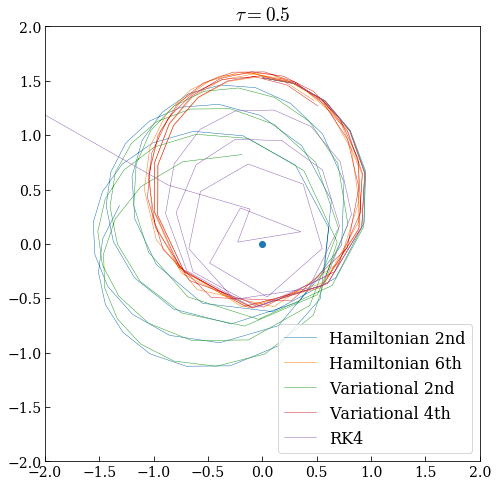

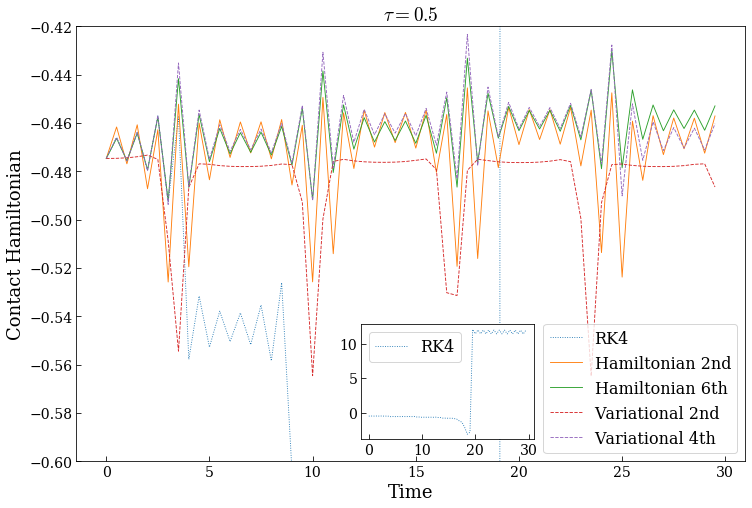

In [7]:
tpk = TimePerturbedKepler(-0.07, 2*np.pi, -1)
dt = 0.5
tf = 30

tspan = np.arange(0.0, tf, dt)

for (p0, q0) in [init]:
    plt.figure(figsize=(12,8))
    plt.title(f"$\\tau={dt}$")
    
    sol, sols, tspan = ic.integrate(ic.step, tpk, tspan, p0, q0, 0.0)
    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)
    solrk = rk4(tpk, np.concatenate([p0,q0]), tspan)
    solsc, solscs, _ = ic.integrate(ic.variational_step, tpk, tspan, p0, q0, 0.0)
    sollag, sollags, _ = ic.integrate(ic.step_lag4, tpk, tspan, p0, q0, 0.0)
    
#     sole, _, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
#     solb, _, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
#     solc, _, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    
    plt.plot(sol[:,1,0],
             sol[:,1,1],
             linewidth=0.5, label="Hamiltonian 2nd")
    plt.plot(solm[:,1,0],
             solm[:,1,1],
             linewidth=0.5, label="Hamiltonian 6th")
    
    plt.plot(solsc[:,1,0],
             solsc[:,1,1],
             linewidth=0.5, label="Variational 2nd")
    plt.plot(sollag[:,1,0],
             sollag[:,1,1],
             linewidth=0.5, label="Variational 4th")
    
    plt.plot([rk[2] for rk in solrk],
             [rk[3] for rk in solrk],
             linewidth=0.5, label="RK4")
    
#     plt.plot(sole[:,1,0],
#              sole[:,1,1],
#              linewidth=0.5, label="Hamiltonian 6th e")
#     plt.plot(solb[:,1,0],
#              solb[:,1,1],
#              linewidth=0.5, label="Hamiltonian 6th b")
#     plt.plot(solc[:,1,0],
#              solc[:,1,1],
#              linewidth=0.5, label="Hamiltonian 6th c")

    plt.scatter(0,0)
    
    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    
    plt.legend()
    plt.show()
    
    fig = plt.figure(figsize=(12,8))
    
    axL = fig.add_subplot(1,1,1)
    axS = fig.add_axes([0.455,0.163,0.2,0.2])
    axS.plot(tspan,
             [tpk.energy(solrk[i][:2], solrk[i][2:], 0.0, t) for i,t in enumerate(tspan)],
             ":",
             linewidth=0.9, label="RK4")
    axS.legend(loc='upper left')
    
    axL.set_title(f"$\\tau={dt}$")
    axL.plot(tspan,
             [tpk.energy(solrk[i][:2], solrk[i][2:], 0.0, t) for i,t in enumerate(tspan)],
             ":",
             linewidth=0.9, label="RK4")
    
    axL.plot(tspan,
             energy(sol, sols),
             linewidth=0.9, label="Hamiltonian 2nd")

    axL.plot(tspan,
             energy(solm, solms),
             linewidth=0.9, label="Hamiltonian 6th")
    
    axL.plot(tspan,
             energy(solsc, solscs),
             '--',
             linewidth=0.9, label="Variational 2nd")
    
    axL.plot(tspan,
             energy(sollag, sollags),
             '--',
             linewidth=0.9, label="Variational 4th")
    
    axL.legend(loc='lower right')
    axL.set_ylim(-0.6,-0.42)
    axL.set_ylabel("Contact Hamiltonian")
    axL.set_xlabel("Time")
    plt.show()

In [8]:
## Small eccentricity

In [9]:
(p0, q0) = init_ecc(0.01) # Plot 0.01, 0.4

tpk = TimePerturbedKepler(-0.07, 2*np.pi, -1)
tf = 80

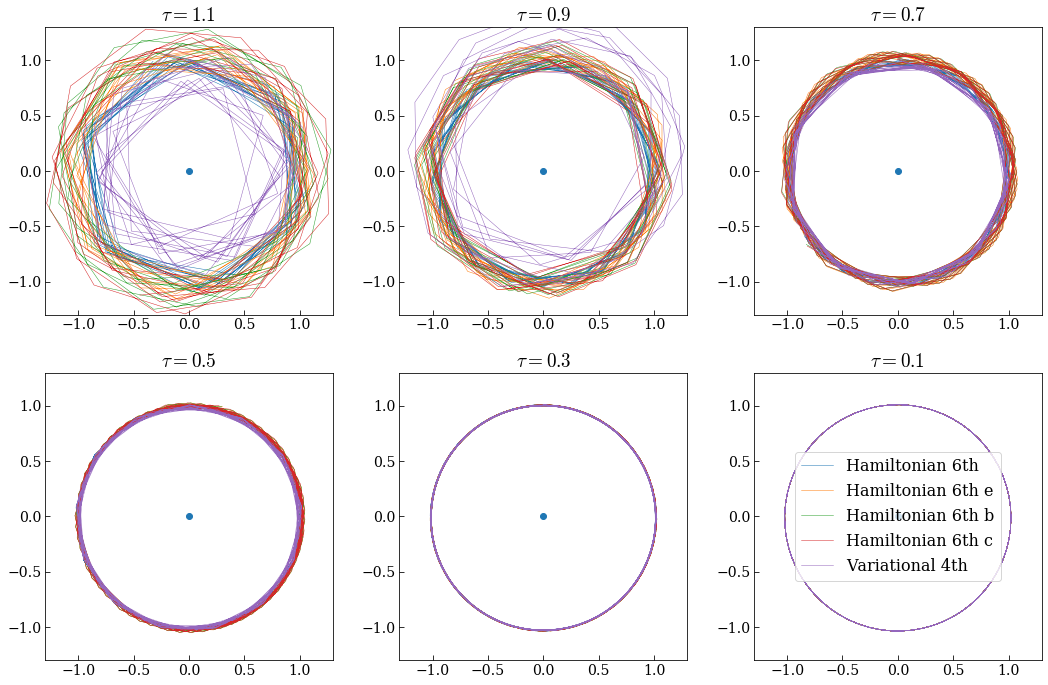

In [10]:
plt.figure(figsize=(18,18))

for i, dt in enumerate([1.1, 0.9, 0.7, 0.5, 0.3, 0.1]):
    tspan = np.arange(0.0, tf, dt)

    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)

    sole, _, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
    solb, _, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
    solc, _, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    sollag, _, _ = ic.integrate(ic.step_lag4, tpk, tspan, p0, q0, 0.0)

    plt.subplot(3,3,i+1)

    plt.title(f"$\\tau={dt}$")
    plt.plot(solm[:,1,0],
             solm[:,1,1],
             linewidth=0.5, label="Hamiltonian 6th")
    plt.plot(sole[:,1,0],
             sole[:,1,1],
             linewidth=0.5, label="Hamiltonian 6th e")
    plt.plot(solb[:,1,0],
             solb[:,1,1],
             linewidth=0.5, label="Hamiltonian 6th b")
    plt.plot(solc[:,1,0],
             solc[:,1,1],
             linewidth=0.5, label="Hamiltonian 6th c")
    plt.plot(sollag[:,1,0],
             sollag[:,1,1],
             linewidth=0.5, label="Variational 4th")

    plt.scatter(0,0)

    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.xlim(-1.3, 1.3)
    plt.ylim(-1.3, 1.3)

    if i == 5: plt.legend()

plt.show()

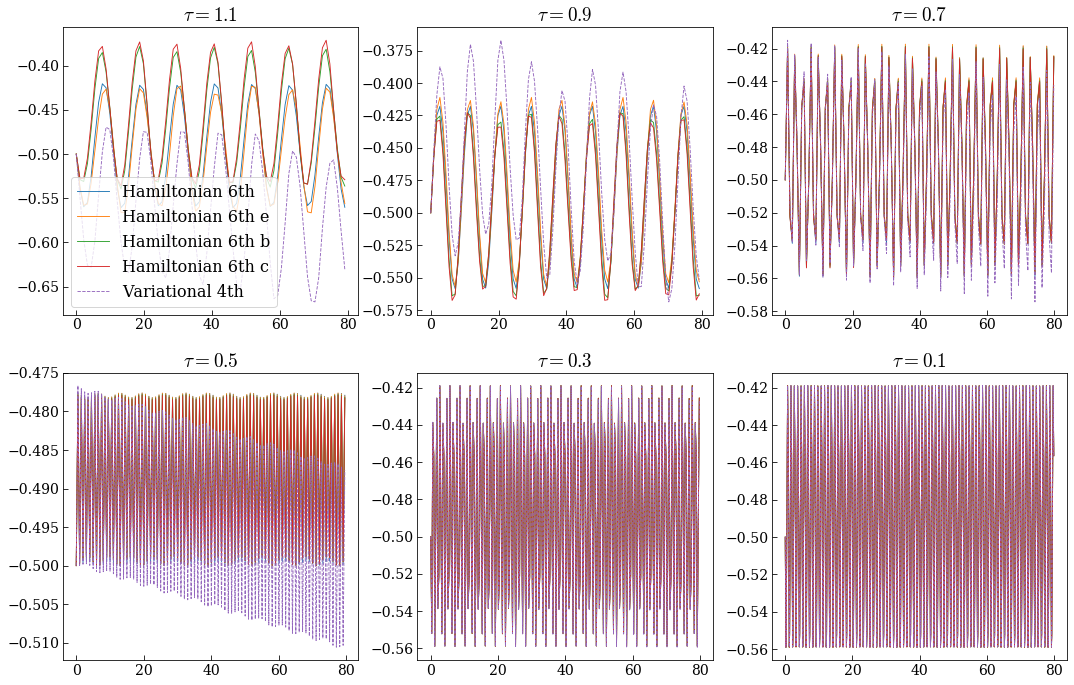

In [11]:
plt.figure(figsize=(18,18))
    
for i, dt in enumerate([1.1, 0.9, 0.7, 0.5, 0.3, 0.1]):
    tspan = np.arange(0.0, tf, dt)

    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)

    sole, soles, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
    solb, solbs, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
    solc, solcs, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    sollag, sollags, _ = ic.integrate(ic.step_lag4, tpk, tspan, p0, q0, 0.0)

    plt.subplot(3,3,i+1)

    plt.title(f"$\\tau={dt}$")
    
    plt.plot(tspan,
             energy(solm, solms),
             linewidth=0.9, label="Hamiltonian 6th")

    plt.plot(tspan,
             energy(sole, soles),
             linewidth=0.9, label="Hamiltonian 6th e")
    
    plt.plot(tspan,
             energy(solb, solbs),
             linewidth=0.9, label="Hamiltonian 6th b")
    
    plt.plot(tspan,
             energy(solc, solcs),
             linewidth=0.9, label="Hamiltonian 6th c")
    
    plt.plot(tspan,
             energy(sollag, sollags),
             '--',
             linewidth=0.9, label="Variational 4th")
    
    #plt.ylabel("Contact Hamiltonian")
    #plt.xlabel("Time")
    
    if i == 0: plt.legend(loc="lower left")

plt.show()

## Large eccentricity

In [12]:
(p0, q0) = init_ecc(0.4)

tpk = TimePerturbedKepler(-0.07, 2*np.pi, -1)
tf = 80

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


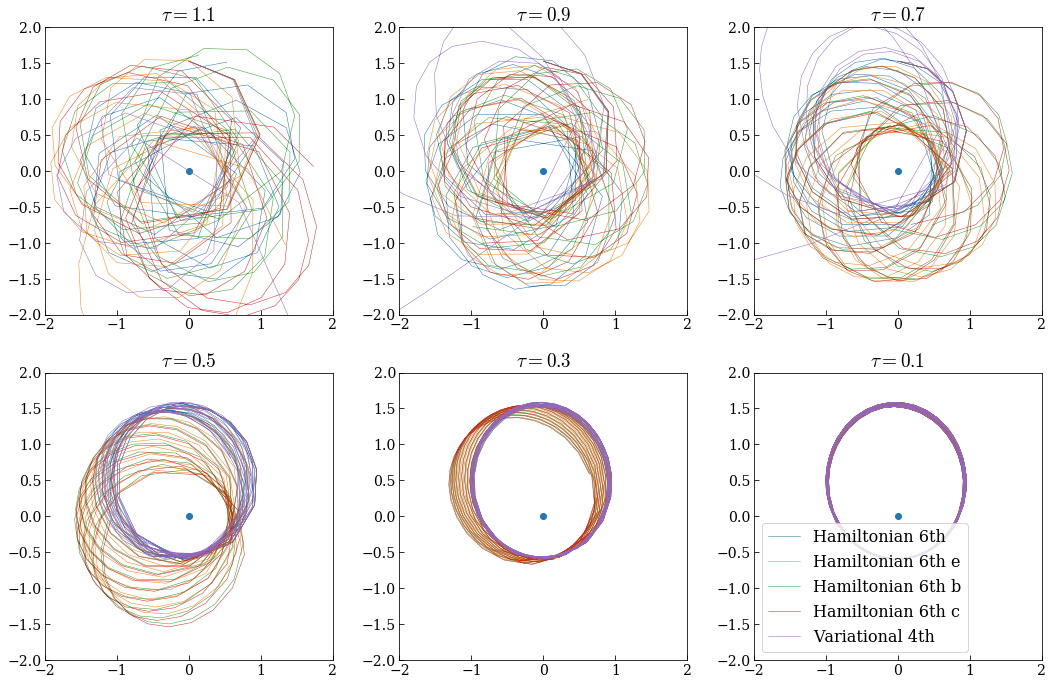

In [13]:
plt.figure(figsize=(18,18))

for i, dt in enumerate([1.1, 0.9, 0.7, 0.5, 0.3, 0.1]):
    tspan = np.arange(0.0, tf, dt)

    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)

    sole, _, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
    solb, _, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
    solc, _, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    sollag, _, _ = ic.integrate(ic.step_lag4, tpk, tspan, p0, q0, 0.0)

    plt.subplot(3,3,i+1)

    plt.title(f"$\\tau={dt}$")
    plt.plot(solm[:,1,0],
             solm[:,1,1],
             linewidth=0.5, label="Hamiltonian 6th")
    plt.plot(sole[:,1,0],
             sole[:,1,1],
             linewidth=0.5, label="Hamiltonian 6th e")
    plt.plot(solb[:,1,0],
             solb[:,1,1],
             linewidth=0.5, label="Hamiltonian 6th b")
    plt.plot(solc[:,1,0],
             solc[:,1,1],
             linewidth=0.5, label="Hamiltonian 6th c")
    plt.plot(sollag[:,1,0],
             sollag[:,1,1],
             linewidth=0.5, label="Variational 4th")

    plt.scatter(0,0)

    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

    if i == 5: plt.legend()

plt.show()

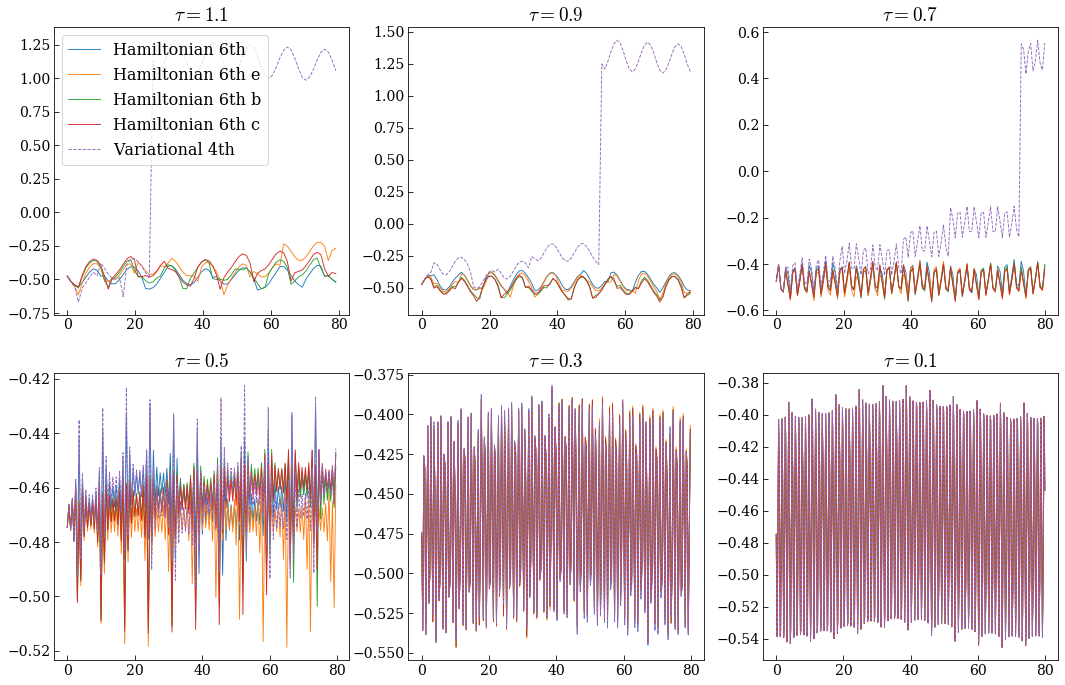

In [14]:
plt.figure(figsize=(18,18))
    
for i, dt in enumerate([1.1, 0.9, 0.7, 0.5, 0.3, 0.1]):
    tspan = np.arange(0.0, tf, dt)

    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)

    sole, soles, _ = ic.integrate(ic.step6e, tpk, tspan, p0, q0, 0.0)
    solb, solbs, _ = ic.integrate(ic.step6b, tpk, tspan, p0, q0, 0.0)
    solc, solcs, _ = ic.integrate(ic.step6c, tpk, tspan, p0, q0, 0.0)
    sollag, sollags, _ = ic.integrate(ic.step_lag4, tpk, tspan, p0, q0, 0.0)

    plt.subplot(3,3,i+1)

    plt.title(f"$\\tau={dt}$")
    
    plt.plot(tspan,
             energy(solm, solms),
             linewidth=0.9, label="Hamiltonian 6th")

    plt.plot(tspan,
             energy(sole, soles),
             linewidth=0.9, label="Hamiltonian 6th e")
    
    plt.plot(tspan,
             energy(solb, solbs),
             linewidth=0.9, label="Hamiltonian 6th b")
    
    plt.plot(tspan,
             energy(solc, solcs),
             linewidth=0.9, label="Hamiltonian 6th c")
    
    plt.plot(tspan,
             energy(sollag, sollags),
             '--',
             linewidth=0.9, label="Variational 4th")
    
#     plt.ylabel("Contact Hamiltonian")
#     plt.xlabel("Time")
    if i == 0: plt.legend(loc="upper left")

plt.show()